In [59]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [32]:
almost_black = '#262626'
plt.rcParams['text.usetex'] = False
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Arial'
plt.rcParams['axes.edgecolor'] = almost_black
plt.rcParams['text.color'] = almost_black
plt.rcParams['axes.linewidth'] = 0.5
plt.rcParams['axes.labelsize'] = 12

In [177]:
company_msci = pd.read_csv("esg_ratings.csv", index_col=0)

In [178]:
company_msci.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6068 entries, 0 to 6067
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ISSUER_NAME                 6068 non-null   object 
 1   ISSUER_TICKER               4458 non-null   object 
 2   ISSUER_CNTRY_DOMICILE_NAME  6068 non-null   object 
 3   IVA_INDUSTRY                5233 non-null   object 
 4   GICS_SUB_IND                5276 non-null   object 
 5   IVA_COMPANY_RATING          2034 non-null   object 
 6   INDUSTRY_ADJUSTED_SCORE     2034 non-null   float64
 7   AGR_RATING                  4828 non-null   object 
 8   GOVERNANCE_SCORE            2087 non-null   float64
dtypes: float64(2), object(7)
memory usage: 474.1+ KB


In [179]:
# With count aggregation we can explore which countries we have very little data of
companies_by_country= company_msci.groupby("ISSUER_CNTRY_DOMICILE_NAME")\
        [['ISSUER_NAME']].size()\
        .sort_values(ascending=False).to_frame()\
        .reset_index()\
        .rename(columns={
            'ISSUER_CNTRY_DOMICILE_NAME': 'Country',
            0: 'Companies'})

In [180]:
companies_by_country.describe()

,Companies
count,35.000000
mean,173.371429
std,257.414873
min,3.000000
25%,21.500000
50%,79.000000
75%,222.000000
max,1359.000000


In [181]:
companies_by_country.head()

,Country,Companies
0,United Kingdom,1359
1,Sweden,624
2,France,522
3,Germany,474
4,Italy,302


In [182]:
companies_by_country.tail()

,Country,Companies
30,Ukraine,13
31,Bosnia and Herzegovina,8
32,Latvia,6
33,Slovakia,5
34,Montenegro,3


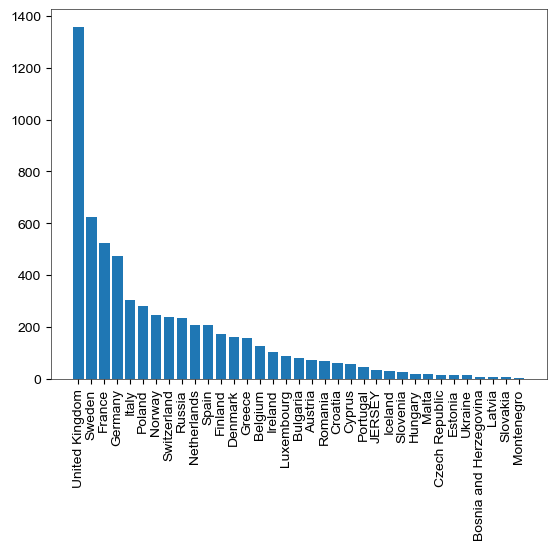

In [183]:
plt.bar(companies_by_country.Country, companies_by_country.Companies)
plt.xticks(rotation=90)

plt.show()

In [214]:
companies_by_country['size_quantile'] = pd.qcut(companies_by_country['Companies'], 4, labels=['Q1', 'Q2', 'Q3', 'Q4'])

In [191]:
from seaborn import boxplot

In [215]:
def getQuantileStats(df, value, quantile_column):
    quantile_stats = df.groupby(quantile_column, observed=True)[value].agg(['min', 'max', 'mean', 'std'])
    return quantile_stats

In [216]:
quantiles = set(companies_by_country['size_quantile'])
quantiles

{'Q1', 'Q2', 'Q3', 'Q4'}

c:\Users\gusta\miniconda3\envs\gus\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


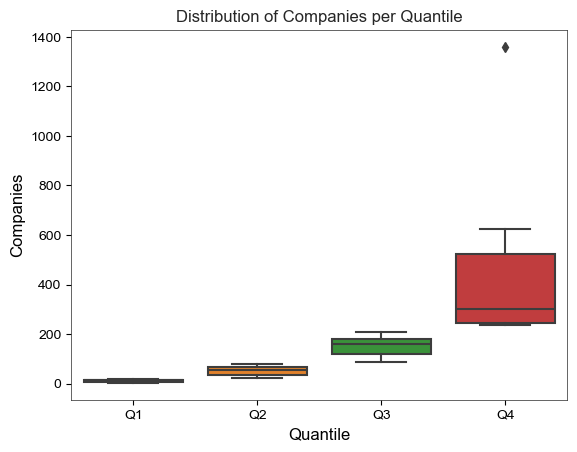

In [220]:
boxplot(data=companies_by_country, x='size_quantile', y='Companies')
plt.xlabel("Quantile")
plt.title("Distribution of Companies per Quantile")
plt.show()

In [218]:
print(getQuantileStats(companies_by_country, 'Companies', 'size_quantile'))

               min   max        mean         std
size_quantile                                   
Q1               3    19   11.222222    5.868939
Q2              24    79   51.444444   19.881594
Q3              89   208  152.750000   43.738672
Q4             236  1359  475.777778  360.419470


In [219]:
companies_by_country.describe()

,Companies
count,35.000000
mean,173.371429
std,257.414873
min,3.000000
25%,21.500000
50%,79.000000
75%,222.000000
max,1359.000000


Fairly divided quantiles in terms of number of companies on the Morgan Stanely Platform, where Q5 has the biggest dispersion

## Next, take a look at each of the statistics given

The IVA rating is the intangible value assessment, it provides a rank based on industry research and analysis of corporate management of environmental and social risk factors. It is used to measure investment risk and opportunity from an ESG lense of each company **Source: MSCI_ESG_IVA.pdf**

In [234]:
iva_rating = company_msci.iloc[:, [0, 2, 5]].dropna()\
    .rename(columns=
            {
                "ISSUER_NAME": 'Company',
                "ISSUER_CNTRY_DOMICILE_NAME": 'Country',
                "IVA_COMPANY_RATING": 'IVA_Rating'
            }).reset_index(drop=True)
iva_rating

,Company,Country,IVA_Rating
0,1&1 AG,Germany,BBB
1,3I GROUP PLC,United Kingdom,AAA
2,4finance Holding S.A.,Luxembourg,B
3,4imprint Group PLC,United Kingdom,AA
4,50Hertz Transmission GmbH,Germany,AAA
...,...,...,...
2029,VERBUND AG,Austria,AAA
2030,VIENNA INSURANCE GROUP AG Wiener Versicherung ...,Austria,BBB
2031,Wienerberger AG,Austria,AAA
2032,ams-OSRAM AG,Austria,BBB


In [239]:
set(iva_rating['IVA_Rating'])

['A', 'AA', 'AAA', 'B', 'BB', 'BBB', 'CCC']

Now we will give the letter scores a value, such that:<br>
AAA = 10 <br>
AA = 9 <br>
A = 8 <br>
BBB = 7 <br>
BB = 6 <br>
B = 5 <br>
CCC = 4 <br>

In [244]:
iva_rating_dictionary = {
    'AAA': 10,
    'AA': 9,
    'A': 8,
    'BBB': 7,
    'BB': 6,
    'B': 5,
    'CCC': 4,
    'CC': 3,
    'C': 2,
    'DDD': 1
}

In [245]:
iva_rating['iva_adjusted'] = iva_rating['IVA_Rating'].map(iva_rating_dictionary)

For the sake of consistency, we will not be looking out countries that have **less than 10 companies**. This is to prevent a few companies from skewing the data

In [260]:
agg_iva = iva_rating.groupby('Country', as_index=False)['iva_adjusted'].agg(['count', 'mean', 'median', 'std']).query('count >= 10')
agg_iva.head()

,Country,count,mean,median,std
0,Austria,36,7.861111,8.0,1.437315
1,Belgium,52,7.961538,8.0,1.251846
6,Denmark,54,8.444444,9.0,1.207940
8,Finland,48,8.979167,9.0,1.061704
9,France,175,8.165714,8.0,1.282496


Text(0, 0.5, 'MSCI Intagible Value Assessment')

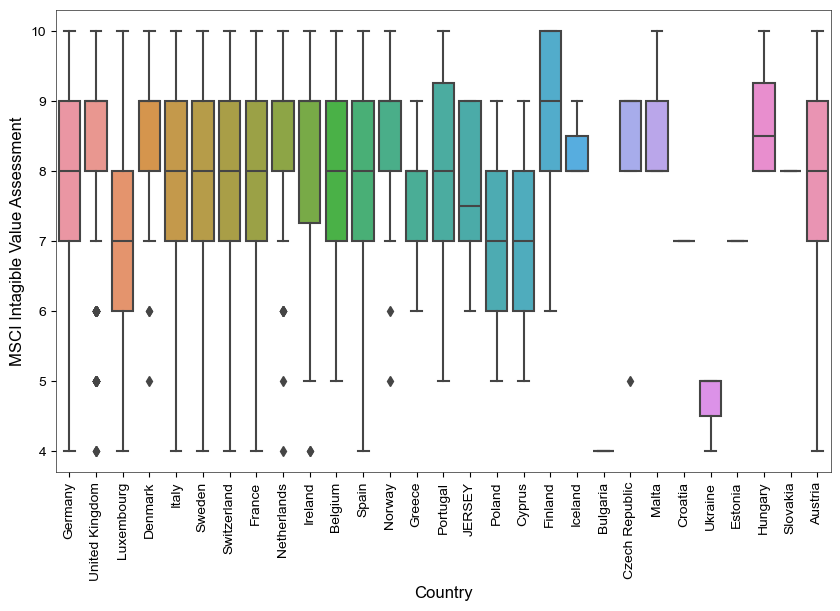

In [276]:
plt.figure(figsize=(10,6))
boxplot(data=iva_rating, x='Country', y='iva_adjusted')

plt.xticks(rotation=90)
plt.ylabel("MSCI Intagible Value Assessment")